In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.set_visible_devices(physical_devices[0], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
# Logical device was not created for first GPU
print(tf.config.list_physical_devices('GPU'))

tc_path = './type-class'
nt_path = './normal-tumor'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Problem 1: Use the Type Classifier to classify the Tumor samples from the NT data set.   Using the type IDs from the Type classifier output for the tumor samples create labelled tumor data that you can use to add to the training/testing data for the Type Classifier.  Retrain the Type classifier on the expanded set of data and report on the results.

My approach is to first speed up and potentially improve the original type classifier. I decided to retrain the original classifier and use only the coding gene data. This allowed significant speed-up. Then I retrain the classifier on the expanded data set and report the results at the end.

In [2]:
# I use just the coding genes as features for all problems
nt_coding = pd.read_csv('./nt.coding.csv')
tc_coding = pd.read_csv('./type.coding.csv')
# nt_all = pd.read_csv('./nt.all.csv')
# tc_all = pd.read_csv('./type.all.csv')

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, model_from_json, model_from_yaml
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau 

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import matplotlib.pyplot as plt
%matplotlib inline
 

In [4]:
def load_data(df,n_classes):
        '''Load, preprocess, and split data'''
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:].astype('float32'), df.Type.astype('int'), test_size=0.2, random_state=11)

        Y_train = tf.keras.utils.to_categorical(y_train,n_classes)
        Y_test = tf.keras.utils.to_categorical(y_test,n_classes)
              
        scaler = MaxAbsScaler()
        mat = np.concatenate((X_train, X_test), axis=0)
        mat = scaler.fit_transform(mat)
        
        X_train = mat[:X_train.shape[0], :]
        X_test = mat[X_train.shape[0]:, :]

        x_train_len = X_train.shape[1]

        # this reshaping is critical for the Conv1D to work
        X_train = np.expand_dims(X_train, axis=2)
        X_test = np.expand_dims(X_test, axis=2)
        
        return X_train, Y_train, X_test, Y_test

In [5]:
EPOCH = 100
BATCH = 32
CLASSES = 36

PL = 19562   # 1 + 60483 these are the width of the RNAseq datasets
P     = 19561   # 60483
DR    = 0.1 

def build_model(n_classes):
    '''Builds the model.'''
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=20, strides=1, padding='valid', input_shape=(P, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=64, kernel_size=10, strides=1, padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=10))
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    
    model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

In [6]:
def train_model(model, X_train, Y_train, X_test, Y_test, name):
    '''Trains the given model'''
    early = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max',
        baseline=None, restore_best_weights=True
    )
    csv_logger = CSVLogger(f'{name}.training.log')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

    history = model.fit(X_train, Y_train,
                        batch_size=BATCH, 
                        epochs=EPOCH,
                        verbose=1, 
                        validation_data=(X_test, Y_test),
                        callbacks = [early, csv_logger, reduce_lr])
    return model

In [7]:
def evaluate_model(model, X_test, Y_test):
    '''Evaluates the model.'''
    from sklearn.metrics import f1_score

    ytrue = np.argmax(Y_test, axis=-1)
    ypred = np.argmax(model.predict(X_test), axis=-1)
    score = model.evaluate(X_test, Y_test, verbose=0)

    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print('Test AUC:', score[2])
    print('Test weighted F1 score:', f1_score(ytrue, ypred, average='weighted'))


    print('Confusion Matrix:\n', tf.math.confusion_matrix(
        ytrue, ypred, weights=None, dtype=tf.dtypes.int32,
        name=None
    ))


In [8]:
# Build, train and evaluate the initial type classifier
X_train, Y_train, X_test, Y_test = load_data(tc_coding, 36)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

model = build_model(CLASSES)
model = train_model(model, X_train, Y_train, X_test, Y_test, 'q1a')
evaluate_model(model, X_test, Y_test)

model.save_weights("q1a.model.h5")
print("Saved model to disk")

X_train shape: (4320, 19561, 1)
X_test shape: (1080, 19561, 1)
Y_train shape: (4320, 36)
Y_test shape: (1080, 36)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19542, 64)         1344      
_________________________________________________________________
activation (Activation)      (None, 19542, 64)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3908, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3899, 64)          41024     
_________________________________________________________________
activation_1 (Activation)    (None, 3899, 64)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 389, 64)           0         
________

# Problem 1b:  Retrain the Type classifier on the expanded set of data and report on the results.

Here, I extract the tumor data from the NT dataset and then classify the tumor types with the original type classifier (from 1a). I concatenate this data to the original type classifier data and retrain the classifier. I also checked the distribution of types to see how balanced or imbalanced the dataset is.

In [9]:
def scale_data(X_df):
        X_df = X_df.astype(np.float32)
        scaler = MaxAbsScaler()
        mat = scaler.fit_transform(X_df)
        return mat

In [10]:
# Log transform and zero all -inf values
# I want to expand the tumor type dataset so I take the nt_coding data and extract just the tumor samples.
# The extracted samples are then preprocessed the same as the training samples.
X = nt_coding.copy()
X.iloc[:,1:] = X.iloc[:,1:].transform(np.log).replace(to_replace = np.NINF, value = 0)
X_tumor = X[X.Type == 1].reset_index(drop=True)
X_tumor_scaled = scale_data(X_tumor.iloc[:,1:])
X_tumor_input = np.expand_dims(X_tumor_scaled, axis=2)

In [11]:
# Get the predictions and use those as labels for the additional data
y_preds = model.predict(X_tumor_input, batch_size = BATCH)
X_tumor.Type = np.argmax(y_preds, axis=1)
tot = pd.concat([X_tumor, tc_coding])

In [12]:
tot.head()

,Type,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,...,ENSG00000269699.4,ENSG00000269711.1,ENSG00000269741.4,ENSG00000269749.1,ENSG00000269755.1,ENSG00000269846.1,ENSG00000269855.2,ENSG00000269858.4,ENSG00000269881.1,ENSG00000269883.1
0,12,11.817720,0.000000,13.525503,11.231949,10.236058,10.932715,11.683766,13.473662,12.432776,...,5.776606,0.0,6.852369,6.49404,7.349324,5.387506,9.700025,10.911068,8.523233,0.000000
1,4,13.014913,8.370332,13.082076,10.618813,9.832910,12.069463,10.026306,14.546522,13.024953,...,0.000000,0.0,0.000000,0.00000,7.075009,8.157713,0.000000,11.129652,9.103908,0.000000
2,5,13.570081,5.689703,13.063701,11.312691,9.992821,10.637658,12.385566,12.962867,12.088561,...,0.000000,0.0,5.506864,0.00000,7.390113,5.833760,8.815045,11.145116,7.304479,0.000000
3,3,12.420320,8.263382,13.239291,10.555530,9.740280,11.859855,13.454218,13.523871,11.276741,...,5.826125,0.0,5.515593,0.00000,7.804307,0.000000,0.000000,11.505592,8.502792,0.000000
4,12,10.991687,7.518864,13.576669,11.257765,10.604674,12.356410,14.241380,13.129423,11.862458,...,6.547944,0.0,0.000000,0.00000,8.274812,0.000000,5.807924,11.265453,8.209381,6.057508


<AxesSubplot:>

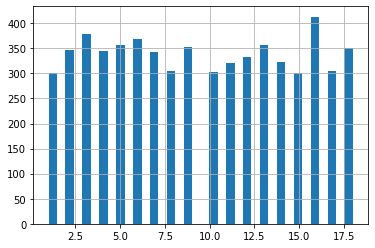

In [13]:
# Check the distribution of classes.
tot.Type.hist(bins=36)


In [14]:
# Retrain on the expanded dataset.
CLASSES=36
X_train, Y_train, X_test, Y_test = load_data(tot, 36)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

model = build_model(CLASSES)
model = train_model(model, X_train, Y_train, X_test, Y_test, 'q1b')
evaluate_model(model, X_test, Y_test)

model.save_weights("q1b.model.h5")
print("Saved model to disk")

X_train shape: (4880, 19561, 1)
X_test shape: (1220, 19561, 1)
Y_train shape: (4880, 36)
Y_test shape: (1220, 36)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 19542, 64)         1344      
_________________________________________________________________
activation_5 (Activation)    (None, 19542, 64)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3908, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3899, 64)          41024     
_________________________________________________________________
activation_6 (Activation)    (None, 3899, 64)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 389, 64)           0         
______

# Summary: 1 paragraph write up for each part and section, explaining what you did and your critique of the results, comments on problems or difficulties and possible future approaches that might do better

For this problem, I retrained the original type classifier using the `tc.coding.csv` data. In order to speed up training (without compromising performance), I adjusted the given architecture, reducing the number of filters used in the convolutional layers, and increasing the max pool size. In addition, I implemented early stopping with a patience of 20. With these adjustments, I achieved a final validation accuracy of 97.5% accuracy, an AUC of 0.999, and a weighted F1 of 0.974. I checked many metrics besides accuracy because accuracy can sometimes not be reflective of performance if the classes are imbalanced. In our case, the classes aren't terribly imbalanced; however, the different metrics give us hope that the performance is good. With the confusion matrix, we can see that some datapoints are incorrectly classified. Along the rows is the true labels and along the columns are the predictions.

# Problem 2: Using the “normal” samples from the NT dataset add a “normal” type to the Type Classifier training/testing data and retrain the model.  Report on the results (accuracy, confusion matrix etc.).

For this problem, I first will extract the normal samples from the NT dataset and relabel them with 36 since the tumor types are 0-35 (although we only have 18 tumor types in the dataset). Then, we concatenate this normal set with the expanded dataset from above. Finally, we will retrain the model with this new data.

In [15]:
# Extract the normal samples from the NT dataset and add a normal type to the type classifier data. 
# There are 36 different tumor types (although the data only has 18 types), 
# so the normal type will be labeled as 36 in the new data

normal = nt_coding.copy()
normal.iloc[:,1:] = normal.iloc[:,1:].transform(np.log).replace(to_replace = np.NINF, value = 0)
normal=normal[normal.Type == 0].reset_index(drop=True)
normal.loc[:,'Type'] = [36]*normal.shape[0]
normal.head()


,Type,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,...,ENSG00000269699.4,ENSG00000269711.1,ENSG00000269741.4,ENSG00000269749.1,ENSG00000269755.1,ENSG00000269846.1,ENSG00000269855.2,ENSG00000269858.4,ENSG00000269881.1,ENSG00000269883.1
0,36,11.920159,8.372825,13.478511,10.998672,9.648070,10.759334,12.125389,12.621583,11.527706,...,6.197932,0.000000,0.000000,0.000000,8.617948,6.907444,7.942819,11.291818,8.830148,5.302032
1,36,13.724741,7.752028,13.627373,10.825815,10.324726,11.693486,12.687636,12.358283,12.227883,...,4.989348,0.000000,10.694974,6.805395,0.000000,5.698860,11.578422,10.923966,6.609963,0.000000
2,36,12.792911,12.341353,13.089759,11.154427,9.728496,11.244961,13.508452,13.147186,11.591253,...,6.057227,0.000000,0.000000,0.000000,8.189560,5.380444,7.332110,11.045752,8.370989,0.000000
3,36,11.307804,5.177901,12.802935,10.728146,9.055277,13.440640,11.874253,13.038852,10.722581,...,5.305594,10.065334,0.000000,6.428493,6.878311,0.000000,7.861410,11.549187,7.554817,0.000000
4,36,12.653028,7.085127,13.594145,11.071110,9.540186,11.073946,12.480268,13.190543,11.917140,...,7.723645,0.000000,0.000000,6.543959,7.686925,7.516866,7.389090,11.316137,8.812381,5.623771


<AxesSubplot:>

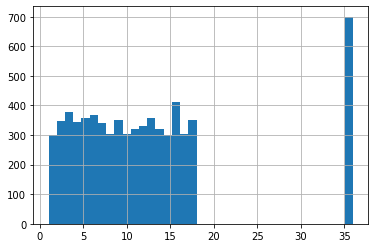

In [16]:
# Concatenate the type classifier expanded dataset from problem 1b with the normal samples from the NT data
# We again check the class distribution
with_normal = pd.concat([tot, normal])
with_normal.Type.hist(bins=37)

Again, I checked the distribution of classes. We see a big gap between 18 and 36 because those are the types that don't exist in our dataset. This will have no impact on performance or model training. We notice from the histogram that there are about 2 times more samples in normal than any of the other classes. This is not drastically imbalanced; however, we can still analyze the **weighted** F1 score which is better for potentially imbalanced dataset since it will consider the number of instances per label.

In [17]:
# Retrain the Type classifier on this new data.
CLASSES = 37
X_train, Y_train, X_test, Y_test = load_data(with_normal, 37)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

model = build_model(CLASSES)
model = train_model(model, X_train, Y_train, X_test, Y_test, 'q2')
evaluate_model(model, X_test, Y_test)

model.save_weights("q2.model.h5")
print("Saved model to disk")

X_train shape: (5440, 19561, 1)
X_test shape: (1360, 19561, 1)
Y_train shape: (5440, 37)
Y_test shape: (1360, 37)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 19542, 64)         1344      
_________________________________________________________________
activation_10 (Activation)   (None, 19542, 64)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3908, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3899, 64)          41024     
_________________________________________________________________
activation_11 (Activation)   (None, 3899, 64)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 389, 64)           0         
______

# Summary: 
The test accuracy of this classifier is 97.6%, auc 0.997, and f1 score 0.976. Even with the new class added, the classifier does well which may indicate that the normal samples are different enough to be able to discern them from thhe other types. Of course, further improvement to the model could be done, perhaps by balancing the classes or optimizing the parameters of the model.

# Problem 3: Using the newly trained Type Classifier that now has the new class of “normal” as one of the categories re-run the classifier on all of the NT data and determine how many of the Normal samples are misclassified?  What could be a possible explanation of this misclassification? Note that you will need to do some strict partitioning of training and testing data to not run the model on the same data it was trained on.

Here, I extract the normal samples from the **test** set from question 2. This ensures that we are not using the data from the training set. We then predict the class and evaluate how well the model predicted the samples. 

In [18]:
# I extract the normal samples from the test data from above. 
# Then I evaluate the model on this data to obtain metrics.
labels = np.argmax(Y_test, axis=-1)
idxs = np.where(labels == 36)
normal_X_test = X_test[idxs]
normal_Y_test = Y_test[idxs]
evaluate_model(model, normal_X_test, normal_Y_test)

Test score: 0.0878828763961792
Test accuracy: 0.9928571581840515
Test AUC: 0.9962620139122009
Test weighted F1 score: 0.996415770609319
Confusion Matrix:
 tf.Tensor(
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 139]], shape=(37, 37), dtype=int32)


In [19]:
normal_X_test.shape[0] # one samples misclassified

140

# Summary: 
The model predicts 99.3% of the given normal samples correctly. As can be seen from the confusion matrix, there is just one sample out of 140 that is misclassified. Although the models prediction accuracy is high, we have to keep in mind that the test set is quite small, so it may be better to analyze a larger set of normal samples in order to get a better reading of the performance.

# Problem 4: Build a new type classifier that attempts to assign the tissue type to the sample independently of whether the sample is Normal or Tumor.  You might want to use the metadata files in the directory to provide information about which samples are of which type.   

For this problem, I use the metadata to build a dataset of tissue type samples. The metadata has pairs primary tumor gene expression and normal gene expression with the tissue type indicated. Once the data has been built, we use this to train and test the model. 

In [20]:
metadata = pd.read_csv('./matched_normal_samples/metadata', sep='\t', header = None)

In [21]:
# I build the tissue type data based on the metadata.
data = []
for i, row in metadata.iterrows():
    tissue = row[1]
    normal =pd.read_csv(f'./matched_normal_samples/normal/{row[4]}', sep= '\t', header=None, index_col=0)
    normal = normal.T
    normal.insert(0,'Type',tissue.lower())
    tumor = pd.read_csv(f'./matched_normal_samples/tumor/{row[6]}', sep= '\t', header=None, index_col=0)
    tumor = tumor.T
    tumor.insert(0,'Type',tissue.lower())
    data.append(normal)
    data.append(tumor)
    
q4_data = pd.concat(data, ignore_index =True)

In [22]:
# See the data.
q4_data.head()

,Type,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
0,prostate,908.971090,441.429189,44095.602873,0.0,53905.323252,216301.394386,0.000000,1164.771110,2.535086e+06,...,0.0,29988.524255,0.0,1463.422844,0.000000,256608.628020,6778.341629,0.0,7493.232006,242.437819
1,prostate,475.025533,0.000000,40006.150839,0.0,40722.086265,204565.633212,0.000000,180.357288,3.562813e+06,...,0.0,159080.638426,0.0,764.780336,0.000000,229729.650111,8576.193419,0.0,6091.462691,0.000000
2,uterus,1194.741346,0.000000,50417.659949,0.0,18940.780352,144624.917524,3008.036722,538.671817,4.668319e+06,...,0.0,134.988281,0.0,6732.272664,2986.853365,175567.812480,5626.974167,0.0,32048.397144,0.000000
3,uterus,2499.746120,0.000000,69987.494384,0.0,71333.310950,287859.456853,0.000000,16016.087270,4.753488e+06,...,0.0,141.217357,0.0,5030.668211,4166.243533,266034.237164,26980.399659,0.0,22733.131638,0.000000
4,head and neck,0.000000,0.000000,106436.627050,0.0,133560.240151,133583.146914,0.000000,4459.424809,5.493713e+06,...,0.0,1548.214268,0.0,3151.596520,0.000000,331576.152148,2689.048772,0.0,3586.059144,0.000000


In [23]:
# I log-transform the data and zero the -inf to match the form that was used for training.          
q4_data.iloc[:,1:] = q4_data.iloc[:,1:].transform(np.log).replace(to_replace = np.NINF, value = 0)
q4_data.head()

,Type,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
0,prostate,6.812313,6.090018,10.694115,0.0,10.894985,12.284428,0.000000,7.060280,14.745738,...,0.0,10.308570,0.0,7.288533,0.000000,12.455307,8.821488,0.0,8.921755,5.490745
1,prostate,6.163369,0.000000,10.596788,0.0,10.614526,12.228644,0.000000,5.194940,15.086061,...,0.0,11.977167,0.0,6.639589,0.000000,12.344658,9.056745,0.0,8.714644,0.000000
2,uterus,7.085685,0.000000,10.828097,0.0,9.849073,11.881899,8.009043,6.289107,15.356310,...,0.0,4.905188,0.0,8.814668,8.001976,12.075781,8.635327,0.0,10.375002,0.000000
3,uterus,7.823944,0.000000,11.156072,0.0,11.175119,12.570228,0.000000,9.681349,15.374389,...,0.0,4.950300,0.0,8.523308,8.334770,12.491380,10.202866,0.0,10.031579,0.000000
4,head and neck,0.000000,0.000000,11.575305,0.0,11.802308,11.802479,0.000000,8.402775,15.519115,...,0.0,7.344857,0.0,8.055664,0.000000,12.711613,7.896943,0.0,8.184809,0.000000


In [24]:
# I map the class name to integers
mapping = {t:i for i, t in enumerate(q4_data.Type.unique())}
q4_data.Type = q4_data.Type.map(mapping)

<AxesSubplot:>

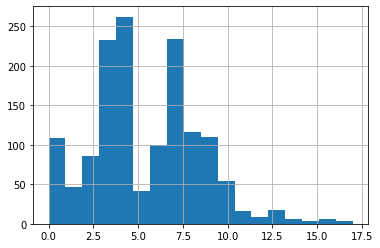

In [25]:
 # Number of tissue types (classes)
q4_data.Type.hist(bins=len(q4_data.Type.unique()))

The classes are very imbalanced.

In [26]:
# I build a tissue type classifier with gene expression as the features.
EPOCH = 100
BATCH = 32
CLASSES = 18

PL = 60484   # 1 + 60483 these are the width of the RNAseq datasets
P     = 60483   # 60483
DR    = 0.1 

X_train, Y_train, X_test, Y_test = load_data(q4_data, CLASSES)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

model = build_model(CLASSES)
model = train_model(model, X_train, Y_train, X_test, Y_test, 'q4')
evaluate_model(model, X_test, Y_test)

model.save_weights("q4.model.h5")
print("Saved model to disk")

X_train shape: (1161, 60483, 1)
X_test shape: (291, 60483, 1)
Y_train shape: (1161, 18)
Y_test shape: (291, 18)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 60464, 64)         1344      
_________________________________________________________________
activation_15 (Activation)   (None, 60464, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12092, 64)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12083, 64)         41024     
_________________________________________________________________
activation_16 (Activation)   (None, 12083, 64)         0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1208, 64)          0         
________

# Summary: 
Using the metadata, I put together the data with the expression data as the features and the tissue type as the classes. In total there were 17 classes or tissue types. Then I built the model architecture and trained the model with this data. In total there were about 1400 samples and 20% of those samples were used for testing and the rest for training. The test accuracy was about 94.2%. This is not as good as the previous classifiers. It is likely due to the class imbalance but it could also be that this data needs a slightly different model with different parameters. With more time, we could adjust the model parameters. In addition, not all classes are represented in the test data (due to the imbalance of datasets). We could test the model with a larger test set that has all the classes but with the same distribution as the train set.

# Problem 5: Using ideas discussed in class, use an unsupervised learning method to cluster the Cancer Type sample data and assign your own “types” to the clusters and use those labels to train a type classifier.  Describe your approach and report on the results.

For this problem, I decided to use a dimension reduction technique called UMAP to visualize the data and observe the natural clusters that form. Based on this I can choose various k-values to perform k-means clustering. There were about 10+ clusters in UMAP, so I performed k-means clustering with `k = 10, 12, 14, 16, 18, 20` and made an elbow plot of the within cluster sum of squared errors (SSE). The SSE is a measure of how internally coherent the clusters are. We choose the 'optimal' `k` value which is the `k` that lies at the elbow. Then I perform k-means for that `k` and use the cluster labels as the class types and retrain the classifier with these new 'types'.

In [27]:
# Create elbow plot for various k values
from sklearn.decomposition import PCA

def cluster(method, n_clusters, X, plot=False):
    """Cluster the data with various clustering methods."""
    
    if method=='kmeans':
        from sklearn.cluster import KMeans
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        y=model.labels_
        
    elif method=='agglomerative':
        from sklearn.cluster import AgglomerativeClustering
        model = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
        y=model.labels_

    else:
        print('Invalid clustering method')
        sys.exit()
    if plot:
        plot_clusters(X,y,2)
    if n_clusters>1:
        from sklearn import metrics
        print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, y))
        print("Davies Bouldin Score: %0.3f" % metrics.davies_bouldin_score(X,y))
        print("Calinski Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(X,y))
    return model

def plot_clusters(X,y,n_components):
    """Performs PCA and visualizes the data in either a 2D or 3D plot."""
    
    np.random.seed(0)
    if n_components==2:
        pca=PCA(n_components=2).fit(X)
        pca_2d = pca.transform(X)
        plt.figure(figsize=(16, 10))
        s = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y, cmap='viridis')
        
    elif n_components==3:
        pca = PCA(n_components=3).fit(X)
        pca_3d = pca.transform(X)
        ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
        s = ax.scatter(
            xs=pca_3d[:,0],
            ys=pca_3d[:,1],
            zs=pca_3d[:,2],
            c=y,
            cmap='viridis'
        )
        ax.set_xlabel('pca-one')
        ax.set_ylabel('pca-two')
        ax.set_zlabel('pca-three')
        
    else:
        print("Invalid number of components.")
        
    plt.legend(*s.legend_elements(), loc=1)
    plt.show()


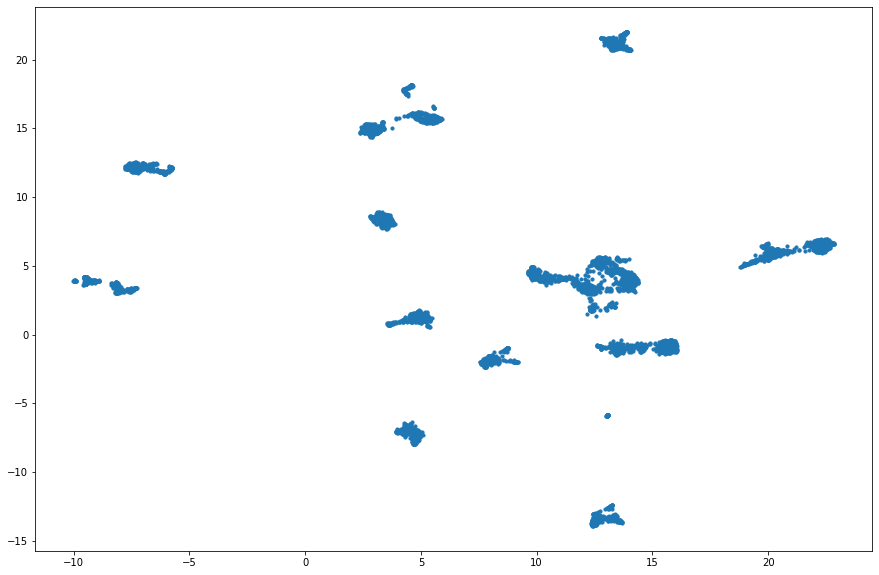

In [28]:
# I use UMAP a dimension reduction technique to visualize the data in 2D. 
# Then I see generally how many natural clusters there are.
import umap

standard_embedding = umap.UMAP(random_state=42).fit_transform(tc_coding.iloc[:,1:])
plt.figure(figsize=(15,10))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=10, cmap='Spectral')

10
Silhouette Coefficient: 0.723
Davies Bouldin Score: 0.366
Calinski Harabasz Score: 18592.627
12
Silhouette Coefficient: 0.796
Davies Bouldin Score: 0.260
Calinski Harabasz Score: 42666.158
14
Silhouette Coefficient: 0.758
Davies Bouldin Score: 0.315
Calinski Harabasz Score: 54439.819
16
Silhouette Coefficient: 0.742
Davies Bouldin Score: 0.355
Calinski Harabasz Score: 67621.010
18
Silhouette Coefficient: 0.756
Davies Bouldin Score: 0.337
Calinski Harabasz Score: 92490.802
20
Silhouette Coefficient: 0.781
Davies Bouldin Score: 0.292
Calinski Harabasz Score: 115155.994


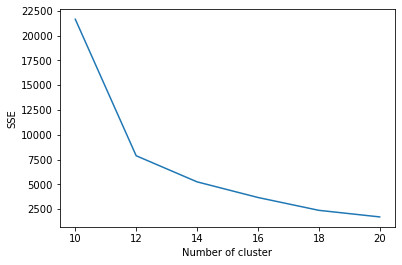

In [29]:
# Based on the UMAP, I test several probable values for k and I use the elbow plot to determine the best k for clustering.
sse={}
for k in [10,12,14,16,18,20]:
    print(k)
    model = cluster('kmeans', k, standard_embedding)
    sse[k] = model.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

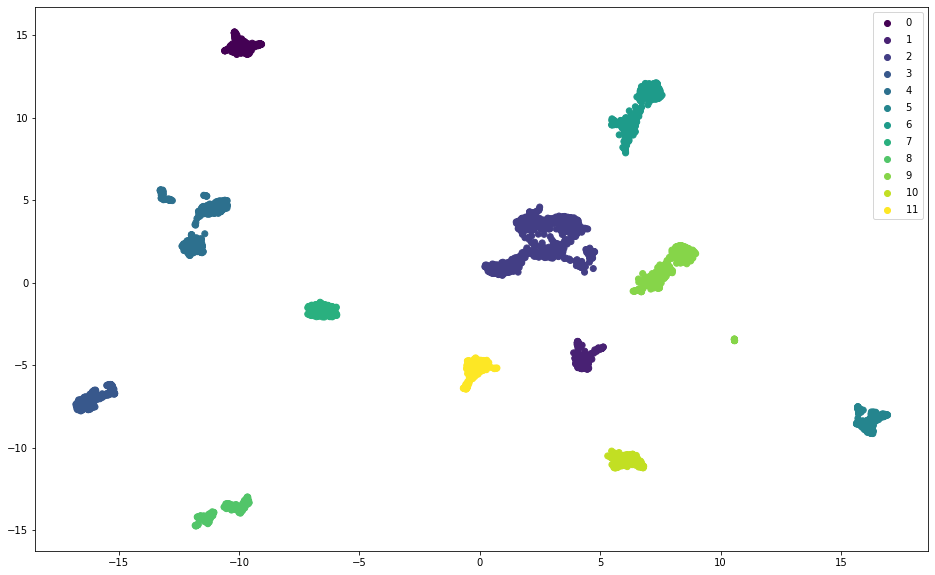

Silhouette Coefficient: 0.796
Davies Bouldin Score: 0.260
Calinski Harabasz Score: 42666.158


In [30]:
model = cluster('kmeans', 12, standard_embedding, plot=True)

In [31]:
# Replace the original Type labels with the new labels predicted from our k-means model.
labels = model.labels_
tc_coding['Type'] = labels
tc_coding.head()

,Type,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,...,ENSG00000269699.4,ENSG00000269711.1,ENSG00000269741.4,ENSG00000269749.1,ENSG00000269755.1,ENSG00000269846.1,ENSG00000269855.2,ENSG00000269858.4,ENSG00000269881.1,ENSG00000269883.1
0,1,19.0,11.7,19.1,17.1,15.5,16.0,18.3,18.9,16.3,...,0.0,0.0,0.0,0.0,11.9,9.4,11.5,16.7,11.2,7.1
1,6,16.5,0.0,21.3,15.5,14.9,17.4,17.6,20.1,17.7,...,10.2,10.8,8.4,10.5,10.2,7.9,13.9,16.2,9.8,7.2
2,0,19.8,9.7,20.4,16.4,14.2,13.9,21.5,20.0,18.7,...,9.6,0.0,0.0,0.0,10.6,10.9,0.0,16.5,9.2,0.0
3,2,16.7,0.0,19.3,15.9,16.1,16.8,16.2,19.2,18.6,...,0.0,0.0,13.6,0.0,10.1,8.9,13.8,15.8,10.2,0.0
4,1,16.4,10.2,19.3,15.5,15.0,15.6,17.3,18.7,17.4,...,8.9,0.0,0.0,0.0,11.6,10.6,11.5,18.6,10.1,12.2


In [32]:
# Train model with the TC data and new "types".
EPOCH = 100
BATCH = 32
CLASSES = len(tc_coding.Type.unique())

PL = 19562   # 1 + 60483 these are the width of the RNAseq datasets
P     = 19561   # 60483
DR    = 0.1 

X_train, Y_train, X_test, Y_test = load_data(tc_coding, CLASSES)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

model = build_model(CLASSES)
model = train_model(model, X_train, Y_train, X_test, Y_test, 'q5')
evaluate_model(model, X_test, Y_test)

model.save_weights("q5.model.h5")
print("Saved model to disk")

X_train shape: (4320, 19561, 1)
X_test shape: (1080, 19561, 1)
Y_train shape: (4320, 12)
Y_test shape: (1080, 12)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 19542, 64)         1344      
_________________________________________________________________
activation_20 (Activation)   (None, 19542, 64)         0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3908, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3899, 64)          41024     
_________________________________________________________________
activation_21 (Activation)   (None, 3899, 64)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 389, 64)           0         
______

# Summary: 
In order to determine my own types, I first visualized the data after transforming the `tc.coding.csv` data with UMAP. UMAP is a dimension reduction technique. We are able to see the data forms natural clusters. Based on this, I choose several k-values to try for k-means. I try values of `k=10,12,14,16,18,20` and I use an elbow plot of the sum of squared errors to determine the best k-value, which we find to be `k=12`. I performed k-means clustering with `k=12` and then use the cluster labels as the "types" for the classifier. With this new data, I train a classifier for the 12 "types". We achieve very high accuracy of 99.1%. This increase in accuracy after re-"typing" is expected since we chose types based on the natural clustering of the data.

# Problem 6: Using any method you like, attempt to produce a model that can generate new data samples labelled as Normal and Tumor and run those newly generated samples through the classifier developed in Step 3.  Report on the results. 

For this problem, I use Gaussian Mixture models to describe the distribution of the `nt.coding.csv` data. GMMs have difficulty converging in high dimensional space (~19,000 features) so first I perform PCA, preserving 99% of the variance in the projected data. Then fit many GMM models with various values for the number of components. We choose the GMM model with low AIC (40 components). I can sample new data from this distribution and I label the samples using a kNN model (10 neighbors) fit with the `nt.coding.csv` data. Then I inverse transform the projected data so that we have the data back in the original space. With this new unseen labeled data, I compare the predictions of the classifier with the labels.

In [33]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

X = nt_coding.iloc[:,1:]
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X)
data.shape

(1400, 66)

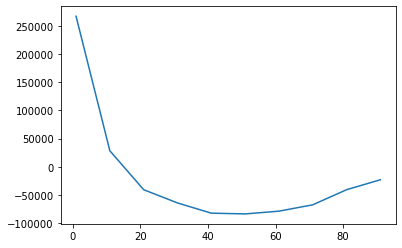

In [34]:
# Figure out how many GMM components to use.
n_components = np.arange(1, 100, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

The above is done to determine the number of component in order to get the best distribution fit.

In [35]:
def get_new_data(X):
    pca = PCA(0.99, whiten=True)
    data = pca.fit_transform(X)
    gmm = GMM(40, covariance_type='full', random_state=0)
    gmm.fit(data)
    all_new_data = gmm.sample(500)
    
    neigh = KNeighborsClassifier(n_neighbors=20)
    neigh.fit(data, nt_coding.Type)
    labels = neigh.predict(all_new_data[0])
    prob = neigh.predict_proba(all_new_data[0])
    # print(prob)
    idxs = np.where(prob==1)[0]
    filtered_new_data = all_new_data[0][idxs]
    filtered_new_labels = labels[idxs]
    
    return all_new_data, filtered_new_data, filtered_new_labels



In [36]:
data_new, new_data, new_labels = get_new_data(nt_coding.iloc[:,1:])

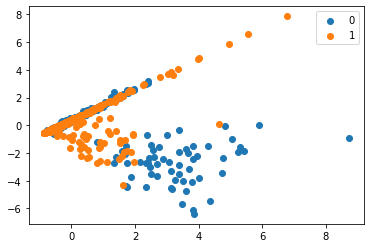

In [37]:
import numpy as np
from matplotlib import pyplot as plt

scatter_x = data[:,0]
scatter_y = data[:,1]
group = nt_coding.Type

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],label = g)
ax.legend()
plt.show()


Above is the original PCA projected data that we use to fit the GMM model.

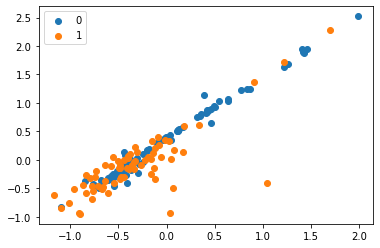

In [38]:
import numpy as np
from matplotlib import pyplot as plt

scatter_x = new_data[:,0]
scatter_y = new_data[:,1]
group = new_labels

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],label = g)
ax.legend()
plt.show()

Above is the new projected data sampled from the fit GMM model. We only keep the new data with labels that the kNN models predicted with high confidence.

In [39]:
# model = tf.keras.models.load_model('q2.model.h5')
new_data = pca.inverse_transform(new_data)
new_s = scale_data(new_data)
new = np.expand_dims(new_s, axis=2)

model = build_model(37)
model.load_weights('q2.model.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 19542, 64)         1344      
_________________________________________________________________
activation_25 (Activation)   (None, 19542, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 3908, 64)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3899, 64)          41024     
_________________________________________________________________
activation_26 (Activation)   (None, 3899, 64)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 389, 64)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 24896)            

In [40]:
# evaluate_model(model, new, l)
# model.predict(new)
ypred = np.argmax(model.predict(new), axis=-1)
ypred = np.where(ypred==36, 0, 1)
ypred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [44]:
new_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [43]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
print(f'Accuracy: {accuracy_score(new_labels,ypred)}')
print(f"F1 score: {f1_score(new_labels,ypred, average='weighted')}")
print(f'Confusion matrix:\n {confusion_matrix(new_labels,ypred)}')

Accuracy: 0.9290322580645162
F1 score: 0.9290972549556771
Confusion matrix:
 [[73 11]
 [ 0 71]]


# Summary:
The model predicted the classes of the new data with fairly high accuracy (92.9%). We can observe the number of TP, TN, FP, FN in the confusion matrix. We see that the model predicted all the normal samples correctly and incorrectly predicted 11 of the 82 tumor samples. This may be due to the fact that there could be more heterogeneity in the tumor group since it is comprised of many different types of tumors. 